# **COVID-19 Detection from Chest X-Rays using Deep Learning**

## Abstract

COVID-19 is an infectious disease caused by a newly discovered coronavirus. The pandemic has become the cause for a dramatic loss of human life. Though there are various vaccines that are being manufactured for coronavirus, lakhs of cases are still arising worldwide. So, in order to prevent the spread of the pandemic, quick and effective testing is necessary. Many researches have recently shown that chest x-rays are found to be highly predictive of COVID-19. Though the chest X-Rays can not solely be used for determining COVID-19, the persons with positive results could be quickly isolated due to the instantaneous nature of the chest X-Ray testing. In our project, we are trying to predict whether a person has COVID-19 from their chest X-Ray scan by image classification using Convolutional Neural Networks in deep learning.

## Environment Setup

In [69]:
# !pip install tensorflow-gpu

In [70]:
!nvidia-smi

Fri May 21 11:14:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    60W / 149W |   8453MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

- Mount Google Drive to access the *CXR* (Chest X-Ray) images dataset.

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import tensorflow as tf
tf.__version__
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- Import required Python modules.

In [73]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob

# Import MatPlotLib tools for plotting graphs and images.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from IPython.display import Image, display

- Define paths for the training dataset, validation dataset, and the testing dataset.



> - Set the train path to the *CXR* (Chest X-Ray) images training dataset.



In [74]:
train_path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/train'

- Set the test path to the CXR (Chest X-Ray) images validating dataset.

In [75]:
val_path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/val'

> - Set the test path to the *CXR* (Chest X-Ray) images testing dataset.



In [76]:
test_path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/test'

In [77]:
# Resize all the images to the resolution 224x224.
IMAGE_SIZE = [224, 224]

# Set batch size.
BATCH_SIZE = 32

# Set number of epochs.
EPOCHS = 10

# Set the learning rate.
LEARNING_RATE = 0.0001

# Set the number of classes.
NUM_CLASSES = 2

- Define classes.

In [78]:
import os

CLASSES = os.listdir(train_path)
NUM_CLASSES = len(CLASSES)

# Print the number of classes.
print("Number of Classes:", NUM_CLASSES)

# Print the list of classes.
print("Classes:", CLASSES)

Number of Classes: 2
Classes: ['COVID', 'Normal']


## Data Preprocessing

### Sample Display

Display a sample image from the *CXR* (Chest X-Ray) image dataset.

- Read a *CXR* (Chest X-Ray) image from the dataset.

In [79]:
img = mpimg.imread(train_path + '/COVID/COVID-300.png')

- Display the grayscale CXR (Chest X-Ray) image as a **pseudocolor** image.

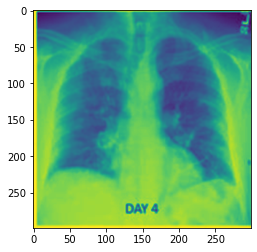

In [80]:
imgplot = plt.imshow(img)

- Display the grayscale *CXR* (Chest X-Ray) image as a **grayscale** image by setting `cmap` (colormap) attribute to `'gray'`.

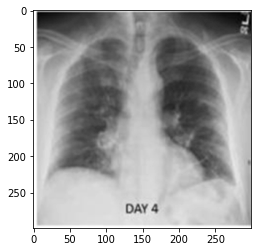

In [81]:
imgplot1 = plt.imshow(img, cmap='gray')

### Load Training Data

- Perform data augmentation on the training data in order to improve the training dataset.

In [82]:
training_data_generator = ImageDataGenerator(rescale = 1./299, zoom_range = 0.2)

- Load the training data from the dataset.

In [83]:
training_set = training_data_generator.flow_from_directory(
    directory = train_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 5426 images belonging to 2 classes.


### Load Validating Data

- Perform data augmentation on validating data.

In [84]:
validating_data_generator = ImageDataGenerator(rescale = 1./299)

- Load the validating data from the dataset.

In [85]:
validation_set = validating_data_generator.flow_from_directory(
    directory = val_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 1446 images belonging to 2 classes.


### Load Testing Data

- Perform data augmentation on the testing data.

In [86]:
testing_data_generator = ImageDataGenerator(rescale = 1./299)

- Load the testing data from the dataset.

In [87]:
test_set = testing_data_generator.flow_from_directory(
    directory = test_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 360 images belonging to 2 classes.


## Build Model

### Import VGG-16 Model

- Import the VGG-16 pre-trained model with imagenet weights but without including the classification layers on the top by setting the attribute `include_top` to `False`.

In [88]:
transfer_model = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# transfer_model = tf.keras.applications.DenseNet201(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


- Do not train existing weights (i.e. imagenet weights).

In [89]:
for layer in transfer_model.layers:
    layer.trainable = False

### Modify the Model

- Add custom layers to our model.

> - Add a pooling layer, then a *Flatten* layer and then add a *Dense* layer to convert the features into single prediction for each *CXR* image.

In [90]:
# Custom layers.
# More layers can be added if required.

# Global average pooling layer.
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(transfer_model.output)

# Max pooling layer.
# max_pooling_layer = tf.keras.layers.MaxPooling2D()(transfer_model.output)

# Flatten layer.
# flatten = Flatten()(max_pooling_layer)
flatten = Flatten()(transfer_model.output)

# Dense layer.
prediction_layers = Dense(NUM_CLASSES, activation = 'softmax')(flatten)

> - Add the VGG-16 feature extraction part and the output prediction part (i.e. our custom layers) to build the required model object.

In [91]:
model = Model(inputs=transfer_model.input, outputs=prediction_layers)

# Print the model summary.
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Compile the Model

Compile the model using **categorical cross-entropy** loss function and **adam** optimizer.

In [92]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = [ 'accuracy' ]
)

## Train the Model

Train the model on the training data using the `keras.fit()` method from the deep learning library **Keras**.
> We are training the model for 10 epochs as previously defined in the constant `EPOCHS`.

In [93]:
history = model.fit(
    training_set,
    validation_data = validation_set,
    epochs = EPOCHS,
    steps_per_epoch = len(training_set),
    validation_steps = len(validation_set)
)

Epoch 1/10
170/170 [==============================] - 122s 655ms/step - loss: 0.4048 - accuracy: 0.8296 - val_loss: 0.4566 - val_accuracy: 0.7835
Epoch 2/10
170/170 [==============================] - 101s 595ms/step - loss: 0.1831 - accuracy: 0.9268 - val_loss: 0.2199 - val_accuracy: 0.9108
Epoch 3/10
170/170 [==============================] - 102s 597ms/step - loss: 0.1401 - accuracy: 0.9469 - val_loss: 0.1584 - val_accuracy: 0.9454
Epoch 4/10
170/170 [==============================] - 104s 610ms/step - loss: 0.1088 - accuracy: 0.9574 - val_loss: 0.1436 - val_accuracy: 0.9474
Epoch 5/10
170/170 [==============================] - 104s 609ms/step - loss: 0.0967 - accuracy: 0.9653 - val_loss: 0.1936 - val_accuracy: 0.9212
Epoch 6/10
170/170 [==============================] - 103s 606ms/step - loss: 0.1029 - accuracy: 0.9636 - val_loss: 0.1672 - val_accuracy: 0.9295
Epoch 7/10
170/170 [==============================] - 105s 617ms/step - loss: 0.0976 - accuracy: 0.9642 - val_loss: 0.2738 -

## Evaluate the Model

### Test the Model

Test the model on the testing data.

In [94]:
testing_steps = 20

loss0, accuracy0 = model.evaluate(test_set, steps = testing_steps)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 6s 277ms/step - loss: 0.1698 - accuracy: 0.9389
loss: 0.17
accuracy: 0.94


### Plot Learning Curves

- `plot_graphs` is a helper function to plot graphs using `matplotlb`.

In [95]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

- Plot a graph of the change in accuracy and loss overtime while training using the variable `history`.

(0.0, 0.4755883254110813)

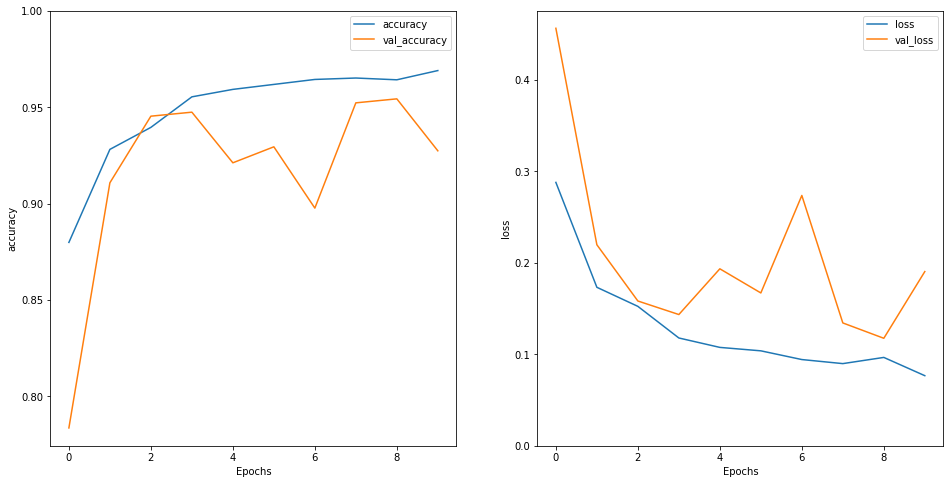

In [96]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

## Save the Model

In [97]:
model.save('cxr-covid-detection-model-vgg16-m')

INFO:tensorflow:Assets written to: cxr-covid-detection-model-vgg16-m/assets


## Load the Model

In [98]:
# Load the saved model.
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/covid-models/cxr-covid-detection-model-50-50-covid-normal')

# Evaluate the loaded model.
loss, accuracy = loaded_model.evaluate(test_set)

model = loaded_model

12/12 [==============================] - 4s 243ms/step - loss: 0.1272 - accuracy: 0.9389


## Predict COVID-19 Status

Predict the status of COVID-19 (i.e. +ve -> present; or -ve -> absent) from a *CXR (Chest X-Ray)* image.

- `model_predict()` is a function that performs prediction for a given CXR image and displays the results in a textual format.

In [99]:
def model_predict(img):
    arr_img = image.img_to_array(img)
    arr_img = np.expand_dims(arr_img, axis = 0)

    # Preprocess the input using VGG-16's preprocess_input() method.
    arr_img_processed = preprocess_input(arr_img)
    
    # Perform prediction.
    result = model.predict(arr_img_processed)
    
    if(result[0][0] < result[0][1]):
        result_str = "-VE (NEGATIVE)"
    else:
        result_str = "+VE (POSITIVE)"
    
    plt.figure()
    plt.imshow(img)
    plt.title('Predicted COVID-19 Status: ' + result_str)
    print("Prediction Result:", result)

- Perform prediction for a *CXR* (Chest X-Ray) image of a normal person.

> - Load a *CXR* (Chest X-Ray) image of a normal person from the dataset.

In [100]:
normal_img = image.load_img(test_path + '/Normal/Normal-1.png', target_size = (224, 224))

> - Display the grayscale CXR (Chest X-Ray) image of a normal person.

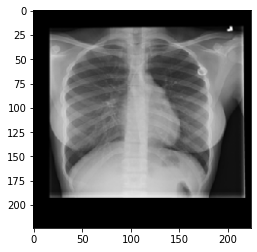

In [101]:
imgplot = plt.imshow(normal_img)

> - Perform prediction for the *CXR* (Chest X-Ray) image of a normal person using the helper function `model_predict()`.

Prediction Result: [[1.0000000e+00 2.0056131e-22]]


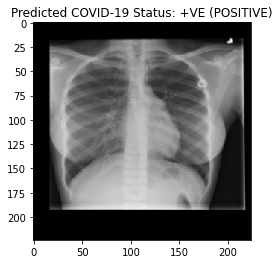

In [102]:
model_predict(normal_img)

- Perform prediction for a *CXR* (Chest X-Ray) image of a COVID affected person.

> - Load a *CXR* (Chest X-Ray) image of a COVID-19 affected person from the dataset.

In [103]:
covid_img = image.load_img(test_path + '/COVID/COVID-44.png', target_size = (224, 224))

> - Display the grayscale CXR (Chest X-Ray) image of the COVID-19 affected person.

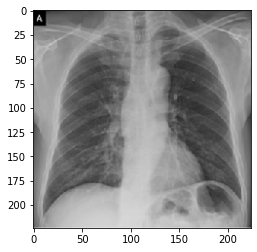

In [104]:
imgplot = plt.imshow(covid_img)

> - Perform prediction for the *CXR* (Chest X-Ray) image of a COVID-19 affected person using the helper function `model_predict()`.

Prediction Result: [[1. 0.]]


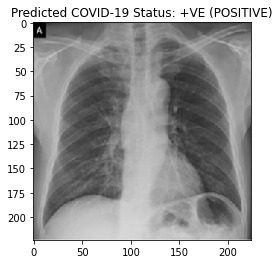

In [105]:
model_predict(covid_img)

## Gradient-weighted Class Activation Map *(Grad-CAM)* Visualization

Prediction Results:
COVID (+VE): 1.0
Normal (-VE): 0.0


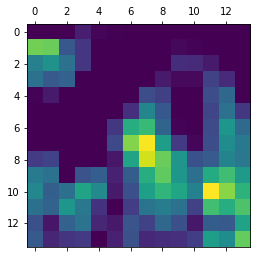

In [109]:
# Function to fetch an image in the form of an array.
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size = size)
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    return img_arr

# Function to generate the Grad-CAM heatmap from https://keras.io/examples/vision/grad_cam/.
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer.
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer.
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1.
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img_size = (224, 224)
last_conv_layer_name = "block5_conv3"
# last_conv_layer_name = "conv5_block32_concat"
img_path = test_path + '/COVID/COVID-44.png'
# img_path = test_path + '/Normal/Normal-5.png'

img_arr = preprocess_input(get_img_array(img_path, size=img_size))

# Remove activation for the outermost layer.
model.layers[-1].activation = None

pred_res = model.predict(img_arr)

print("Prediction Results:")
print("COVID (+VE):", pred_res[0][0])
print("Normal (-VE):", pred_res[0][1])

# Generate Grad-CAM heatmap.
heatmap = make_gradcam_heatmap(img_arr, model, last_conv_layer_name)

# Display heatmap.
plt.matshow(heatmap)
plt.show()

### Superimposed Visualization

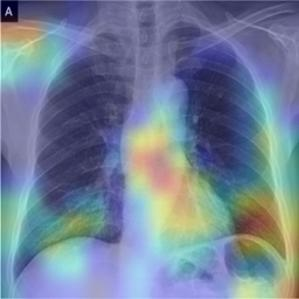

In [110]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)